# Sports Image Classification

In this project, our primary objective is to develop a robust deep learning model capable of accurately classifying various sports types based on their visual characteristics in images. This image classification task addresses a multi-class problem involving a substantial number of distinct sports categories. The dataset utilized for this project comprises a diverse collection of sports images, providing a rich foundation for training and evaluating our model.

We will systematically approach this challenge by following a series of well-defined steps:

1. Import Libraries
2. Loading Images
3. Exploratory Data Analysis
4. Preprocessing
5. Transfer Learning
6. Evaluating the Model on Validation Set
7. Evaluate and Predict on the Test Set
8. Project Report

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import cv2
import random
import math
import json


from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras import layers,models
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2

import warnings 
warnings.filterwarnings('ignore')

## Loading Images

In [3]:
train_dir = "/kaggle/input/sports-classification/train"
val_dir = "/kaggle/input/sports-classification/valid"
test_dir = "/kaggle/input/sports-classification/test"

## Exploratory Data Analysis

In [4]:
class_names = sorted(os.listdir(train_dir))

sample_image_shapes = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    all_files_in_class = os.listdir(class_path)

    random_image_name = random.choice(all_files_in_class)
    image_path = os.path.join(class_path, random_image_name)

    img = cv2.imread(image_path)

    sample_image_shapes.append(img.shape)

if len(sample_image_shapes) > 0:
    first_shape = sample_image_shapes[0]
    all_same_shape = all(s == first_shape for s in sample_image_shapes)
    
    print(f"Size of the first image checked: {first_shape}")
    print(f"Are all sample images the same size: {all_same_shape}")
    if not all_same_shape:
        print("Images with different sizes were detected. All found sizes:", set(sample_image_shapes))

Size of the first image checked: (224, 224, 3)
Are all sample images the same size: True


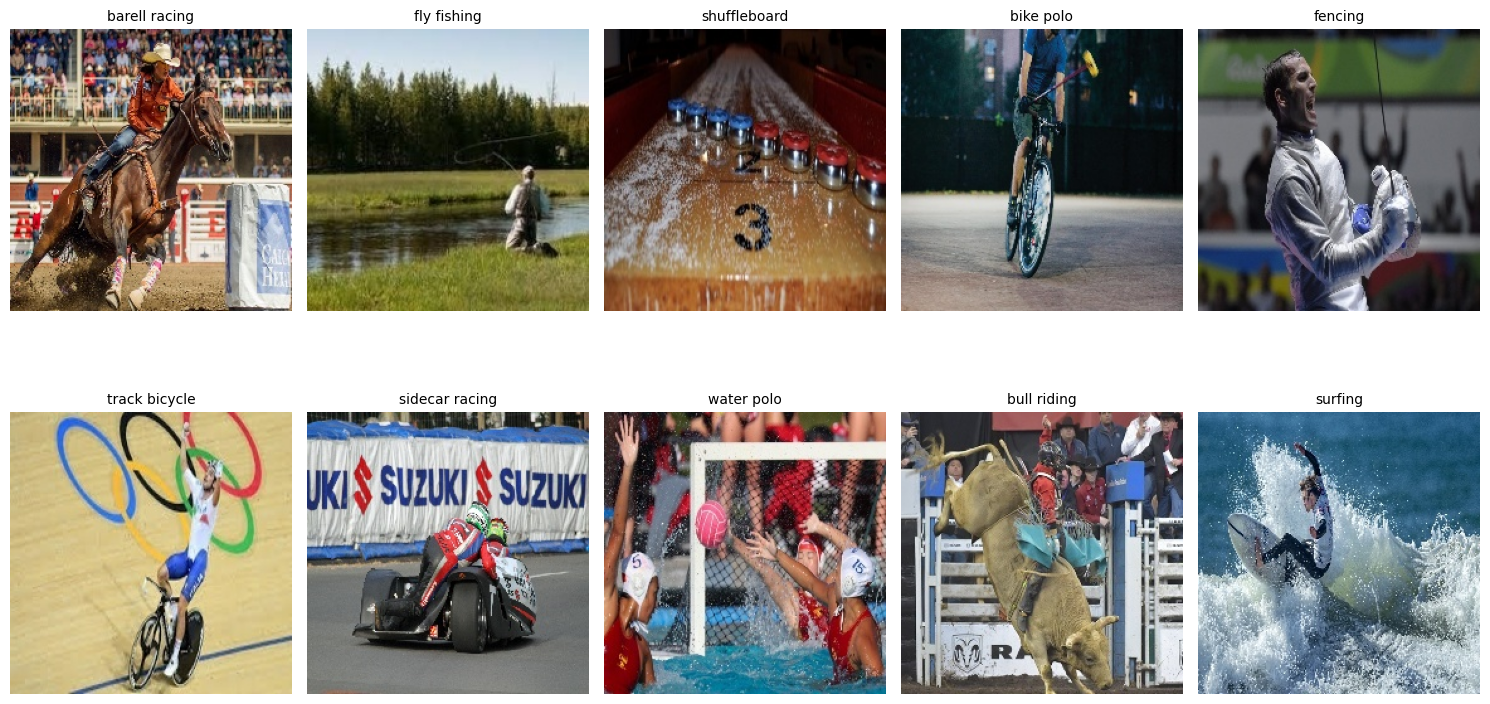

In [5]:
num_display_samples = 10
random_classes_to_display = random.sample(class_names, num_display_samples)

plt.figure(figsize=(15, 12))

for i, class_name in enumerate(random_classes_to_display):
    class_path = os.path.join(train_dir, class_name)
    all_files_in_class = os.listdir(class_path)

    random_image_name = random.choice(all_files_in_class)
    image_path = os.path.join(class_path, random_image_name)

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax = plt.subplot(num_display_samples // 5 + 1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"{class_name}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
for folder in os.listdir(train_dir):
    print(f"{folder}: {len(os.listdir(os.path.join(train_dir, folder)))} images")

bobsled: 138 images
hurdles: 136 images
snow boarding: 117 images
fly fishing: 134 images
luge: 127 images
sidecar racing: 133 images
ampute football: 112 images
volleyball: 142 images
billiards: 145 images
giant slalom: 150 images
tennis: 131 images
horse racing: 139 images
pole dancing: 112 images
figure skating women: 157 images
rollerblade racing: 159 images
fencing: 135 images
olympic wrestling: 167 images
golf: 157 images
ultimate: 97 images
harness racing: 147 images
football: 191 images
frisbee: 131 images
bungee jumping: 125 images
shot put: 149 images
ice climbing: 130 images
figure skating men: 128 images
rowing: 143 images
bike polo: 110 images
swimming: 157 images
judo: 150 images
axe throwing: 113 images
archery: 132 images
baseball: 174 images
wheelchair basketball: 106 images
log rolling: 128 images
lacrosse: 151 images
rock climbing: 141 images
horse jumping: 134 images
hydroplane racing: 108 images
formula 1 racing: 190 images
curling: 141 images
jousting: 118 images


In [10]:
train_class_counts = {}
for sport_class in os.listdir(train_dir):
    class_path = os.path.join(train_dir, sport_class)
    num_images = len(os.listdir(class_path))
    train_class_counts[sport_class] = num_images

class_names = list(train_class_counts.keys())
class_counts = list(train_class_counts.values())

min_count = min(class_counts)
max_count = max(class_counts)
avg_count = sum(class_counts) / len(class_counts)
num_classes = len(class_counts)

print(f"\nTotal {num_classes} different sports classes found.")
print(f"Minimum number of images for each class: {min_count}")
print(f"Maximum number of images for each class: {max_count}")
print(f"Average number of images for each class: {avg_count:.2f}")

if max_count - min_count < avg_count * 0.10:
    print("Class distribution: Looks pretty balanced.")
else:
    print("Class distribution: There may be some imbalances, detailed examination may be necessary.")


Total 100 different sports classes found.
Minimum number of images for each class: 59
Maximum number of images for each class: 191
Average number of images for each class: 134.93
Class distribution: There may be some imbalances, detailed examination may be necessary.


We will conduct **data augmentation** to address class imbalance.

## Preprocessing

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_iterator = train_datagen.flow_from_directory(
    train_dir,
    class_mode='sparse',
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_iterator = val_datagen.flow_from_directory(
    val_dir,
    class_mode='sparse',
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False
    
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_iterator = test_datagen.flow_from_directory(
    test_dir,
    class_mode='sparse',
    color_mode='rgb', 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


## Transfer Learning

In [ ]:
NUM_CLASSES = train_iterator.num_classes

base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                         include_top=False,
                         weights='imagenet')


base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

print("\nThe Transfer Learning model has been successfully created and compiled.")
print("Caution: 'Non-trainable params' indicates the frozen parameters of the base_model.")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,965,156 (11.31 MB)

 Trainable params: 707,172 (2.70 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


The Transfer Learning model has been successfully created and compiled.
Caution: 'Non-trainable params' indicates the frozen parameters of the base_model.


In [ ]:
steps_per_epoch = math.ceil(train_iterator.n / BATCH_SIZE)
validation_steps = math.ceil(val_iterator.n / BATCH_SIZE)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [12]:
history_transfer = model.fit(
    train_iterator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=val_iterator,
    validation_steps=validation_steps,
    callbacks=[early_stopping],
    verbose=1 
)

Epoch 1/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.1063 - loss: 4.2589 - val_accuracy: 0.5200 - val_loss: 2.3167
Epoch 2/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 160s 760ms/step - accuracy: 0.5407 - loss: 2.1223 - val_accuracy: 0.7220 - val_loss: 1.1951
Epoch 3/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 157s 744ms/step - accuracy: 0.6945 - loss: 1.3126 - val_accuracy: 0.7740 - val_loss: 0.8552
Epoch 4/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 160s 757ms/step - accuracy: 0.7510 - loss: 1.0228 - val_accuracy: 0.8160 - val_loss: 0.6892
Epoch 5/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 159s 755ms/step - accuracy: 0.7824 - loss: 0.8721 - val_accuracy: 0.8300 - val_loss: 0.5807
Epoch 6/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 161s 762ms/step - accuracy: 0.8039 - loss: 0.7534 - val_accuracy: 0.8380 - val_loss: 0.5237
Epoch 7/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 164s 779ms/step - accuracy: 0.8137 - loss: 0.7061 - val_accuracy: 0.8640 - val_loss: 0.4817
Epoch 8/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 164s 779ms/step - accuracy: 0.8362 - lo

In [16]:
model_save_path = '/kaggle/working/model.keras'

print(f"\nSaving model to {model_save_path}...")
model.save(model_save_path)
print("Model saved successfully!")

history_save_path = '/kaggle/working/history.json'

print(f"Saving education history to {history_save_path}...")
with open(history_save_path, 'w') as f:
    json.dump(history_transfer.history, f)
print("History object saved successfully!")


Saving model to /kaggle/working/model.keras...
Model saved successfully!
Saving education history to /kaggle/working/history.json...
History object saved successfully!


In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

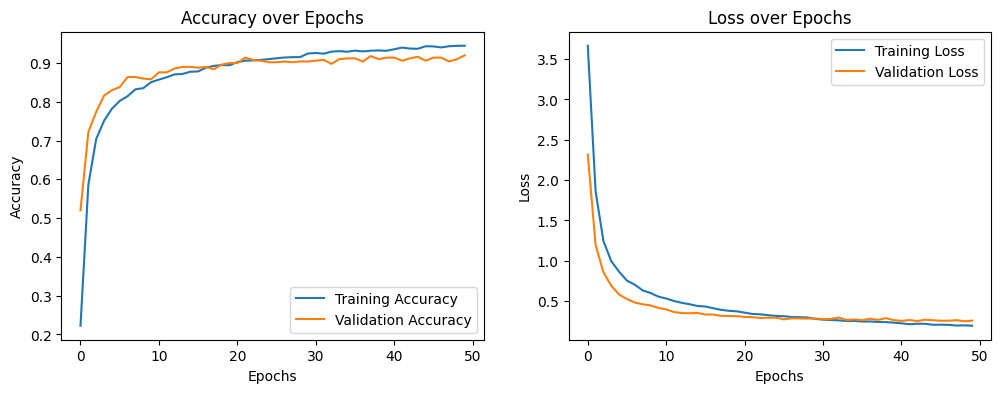

In [15]:
plot_history(history_transfer)

## Evaluating the Model on Validation Set

In [19]:
val_loss, val_accuracy = model.evaluate(val_iterator)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.9262 - loss: 0.2089
Validation Loss: 0.2496
Validation Accuracy: 0.9100


In [36]:
val_predictions = model.predict(val_iterator)
val_predicted_classes = np.argmax(val_predictions, axis=1)


val_true_classes = val_iterator.classes

label_map = dict((v, k) for k, v in train_iterator.class_indices.items())
class_names = [label_map[i] for i in sorted(label_map.keys())]

print(classification_report(val_true_classes, val_predicted_classes, target_names=class_names))

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step
                       precision    recall  f1-score   support

           air hockey       1.00      0.80      0.89         5
      ampute football       0.83      1.00      0.91         5
              archery       1.00      1.00      1.00         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       1.00      0.80      0.89         5
        barell racing       1.00      1.00      1.00         5
             baseball       0.80      0.80      0.80         5
           basketball       0.83      1.00      0.91         5
       baton twirling       0.80      0.80      0.80         5
            bike polo       1.00      1.00      1.00         5
            billiards       0.83      1.00      0.91         5
                  bmx       0.71      1.00      0.83         5
              bobsled       0.80      0.80      0.80         5
              b

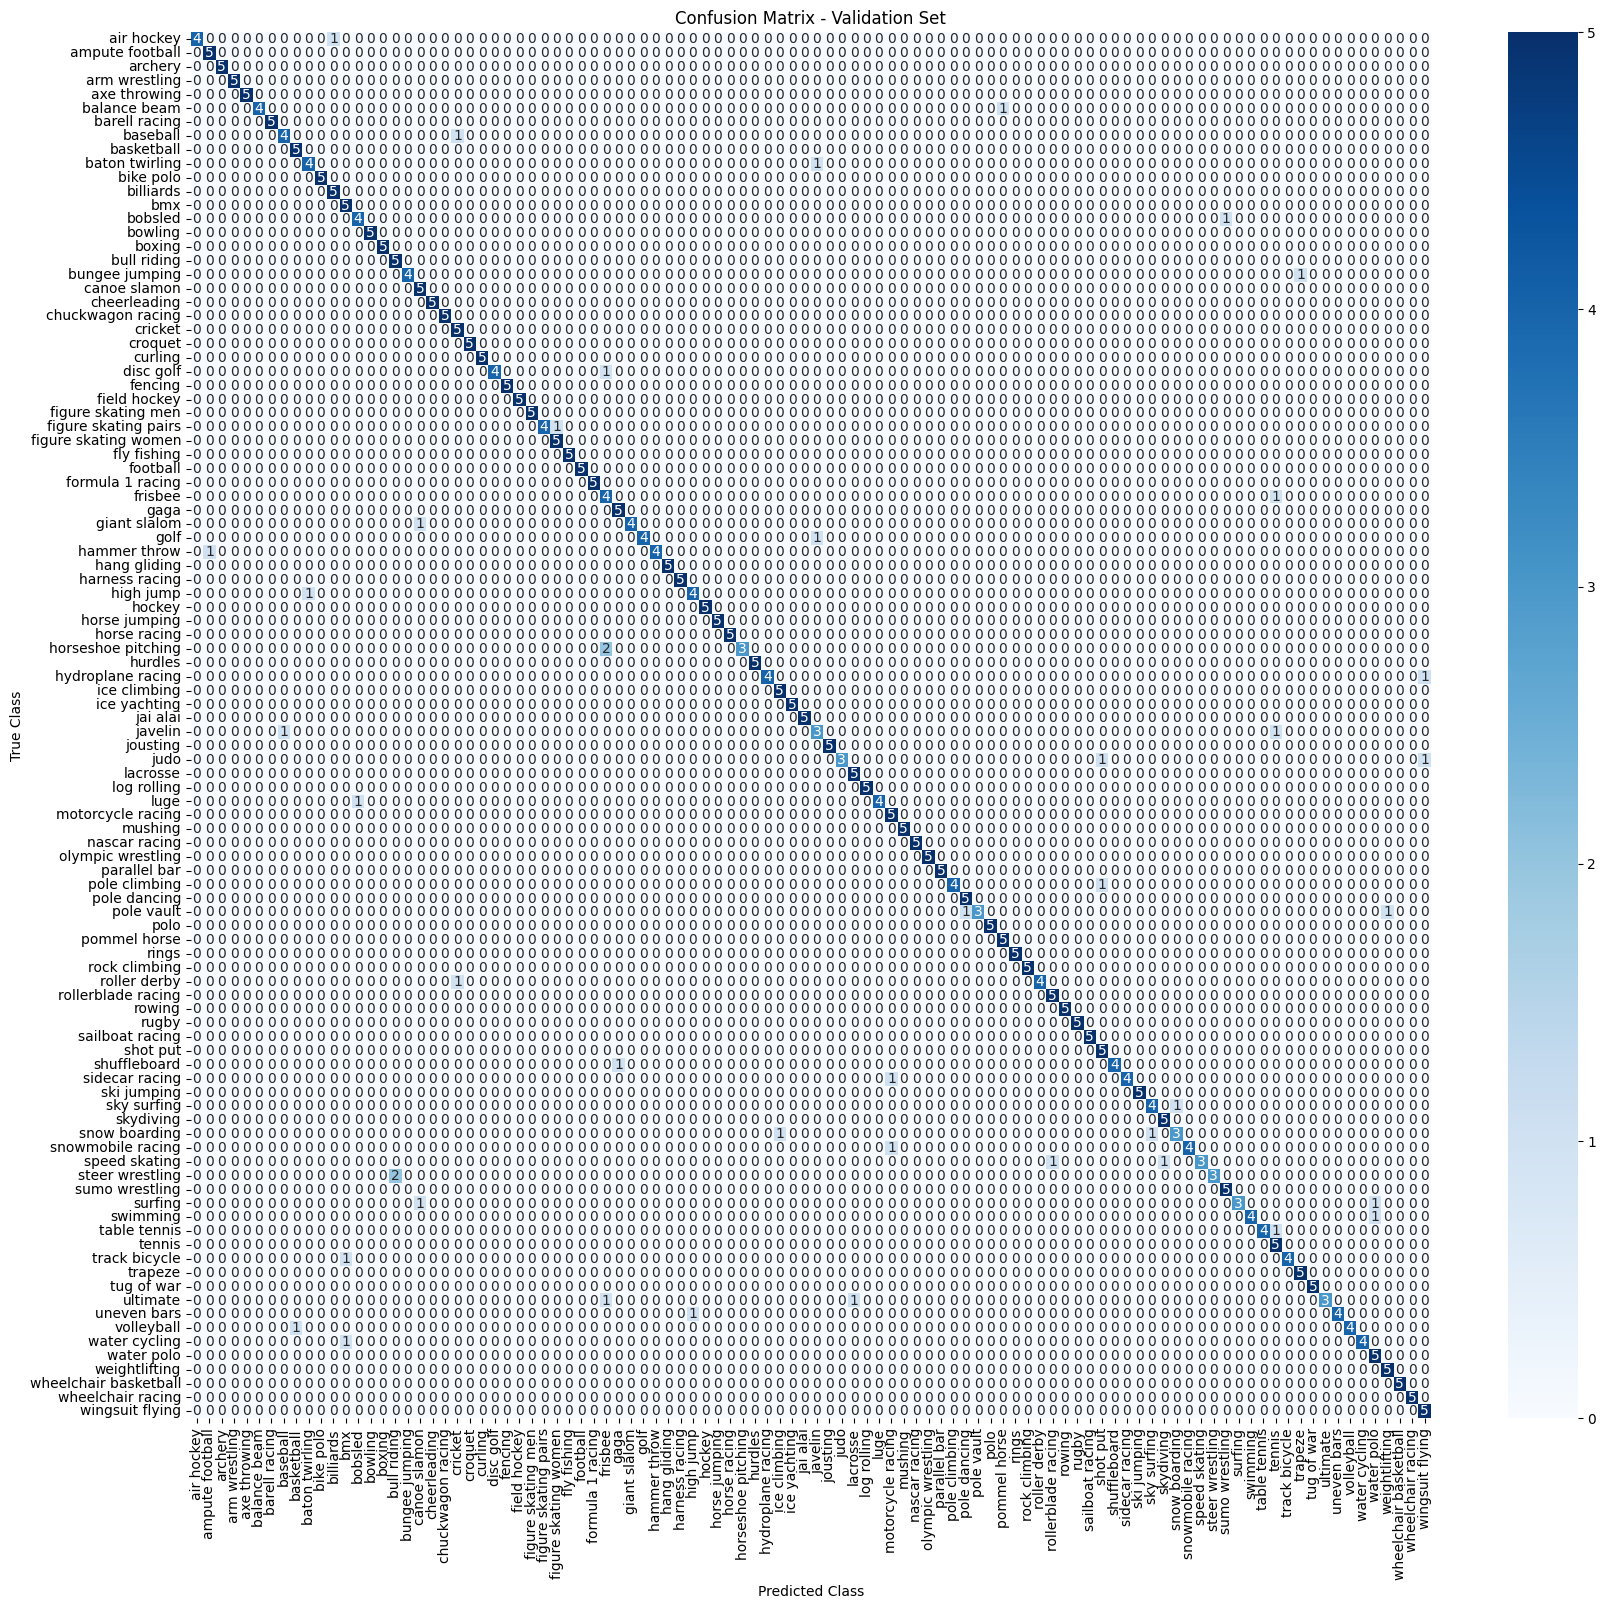

In [30]:
cm = confusion_matrix(val_true_classes, val_predicted_classes)

plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix - Validation Set")
plt.show()

## Evaluate and Predict on the Test Set

In [28]:
test_loss, test_accuracy = model.evaluate(test_iterator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 577ms/step - accuracy: 0.9314 - loss: 0.2156
Test Loss: 0.2004
Test Accuracy: 0.9460


In [34]:
test_predictions = model.predict(test_iterator)
test_predicted_classes = np.argmax(test_predictions, axis=1)

test_true_classes = test_iterator.classes

print(classification_report(test_true_classes, test_predicted_classes, target_names=class_names, zero_division=0))

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step
                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       0.83      1.00      0.91         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       1.00      1.00      1.00         5
        barell racing       1.00      1.00      1.00         5
             baseball       0.75      0.60      0.67         5
           basketball       0.71      1.00      0.83         5
       baton twirling       0.75      0.60      0.67         5
            bike polo       1.00      0.80      0.89         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.60      0.75         5
              bobsled       1.00      1.00      1.00         5
              b

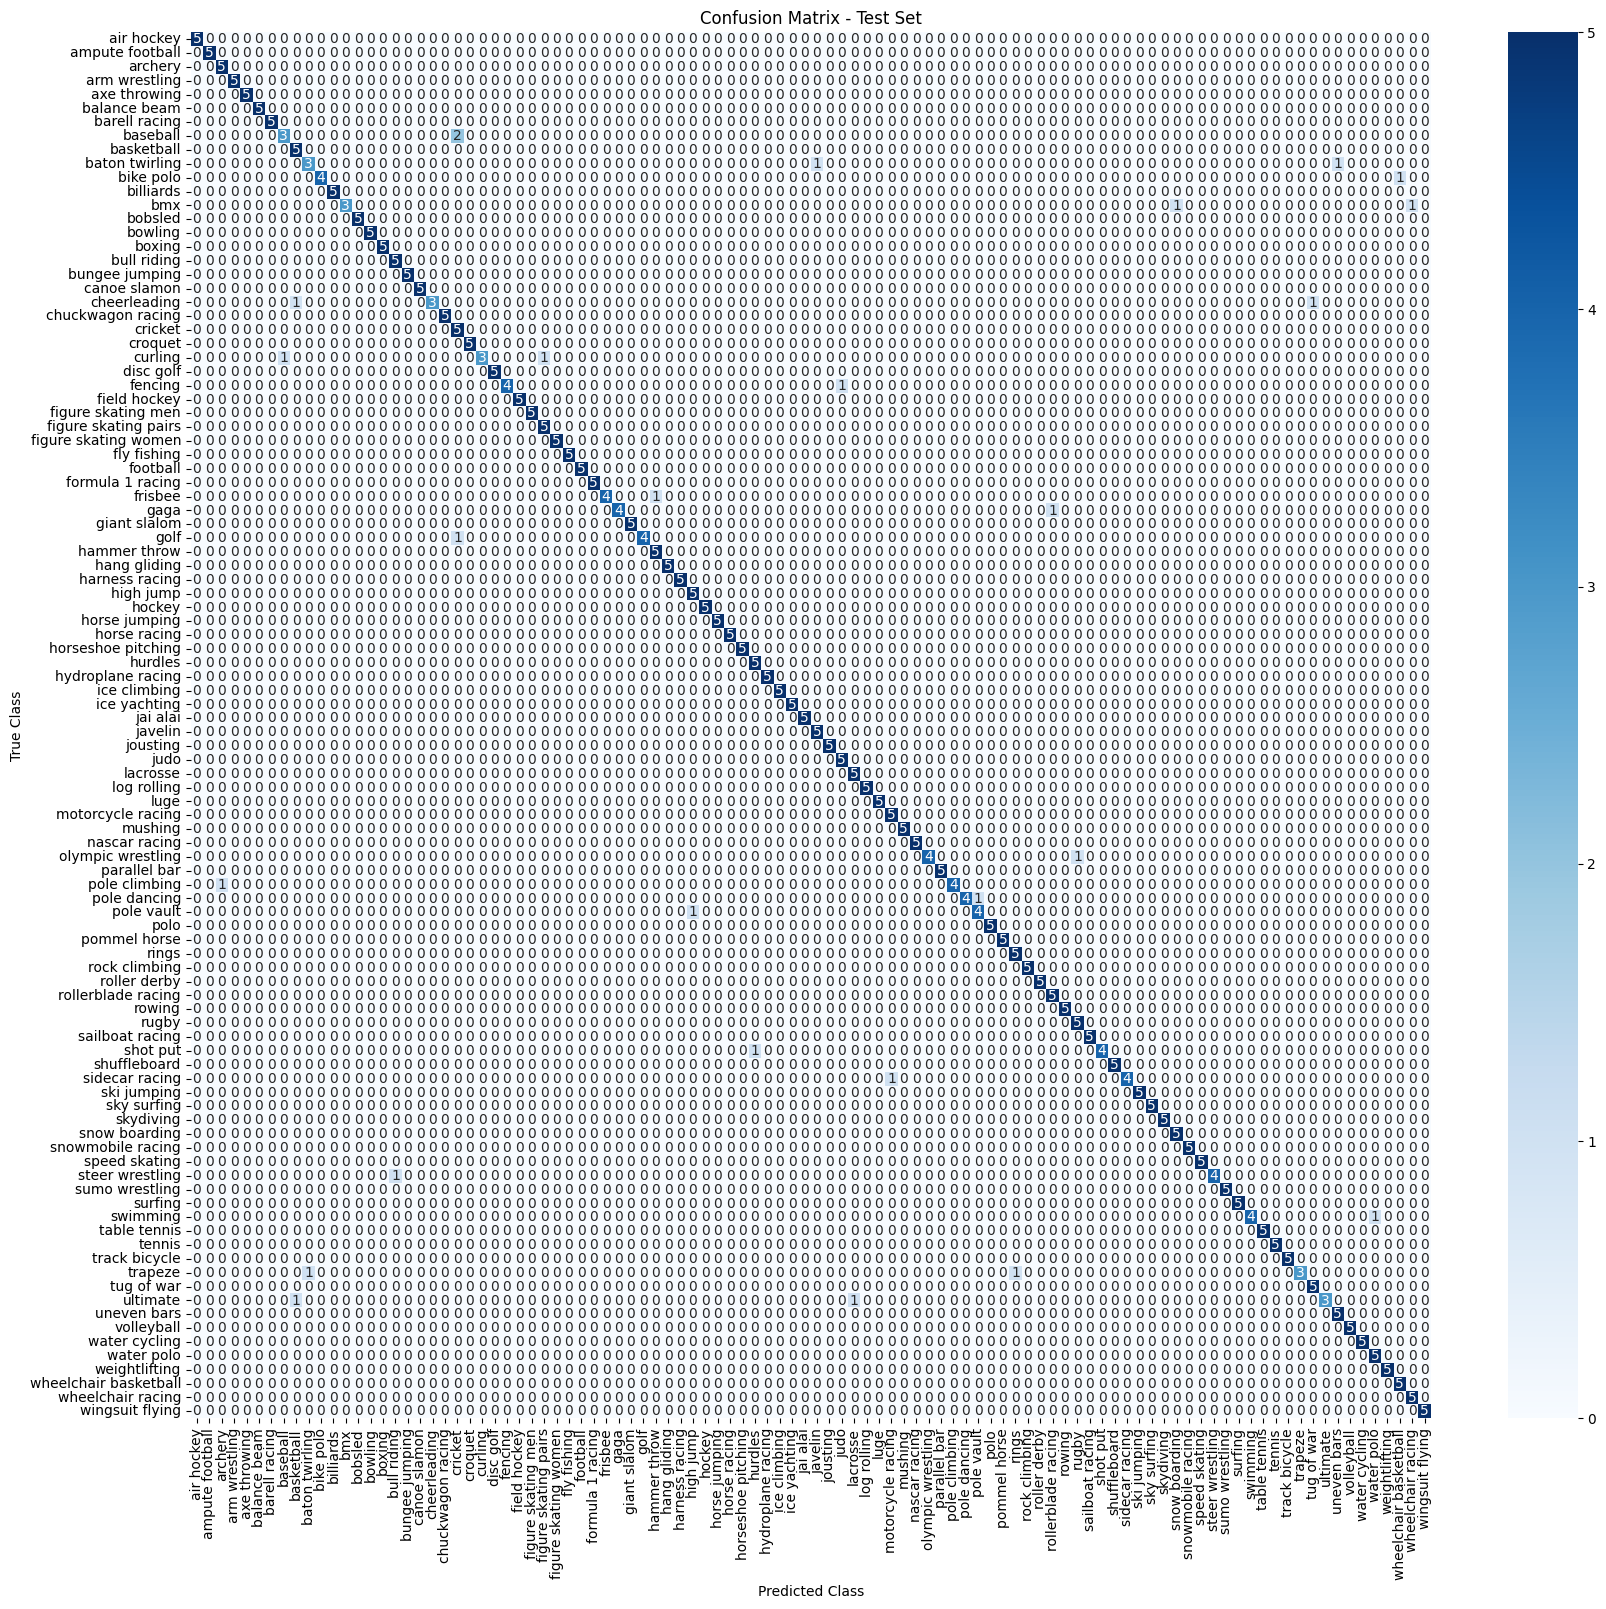

In [35]:
cm_test = confusion_matrix(test_true_classes, test_predicted_classes)

plt.figure(figsize=(20, 18))

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix - Test Set")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


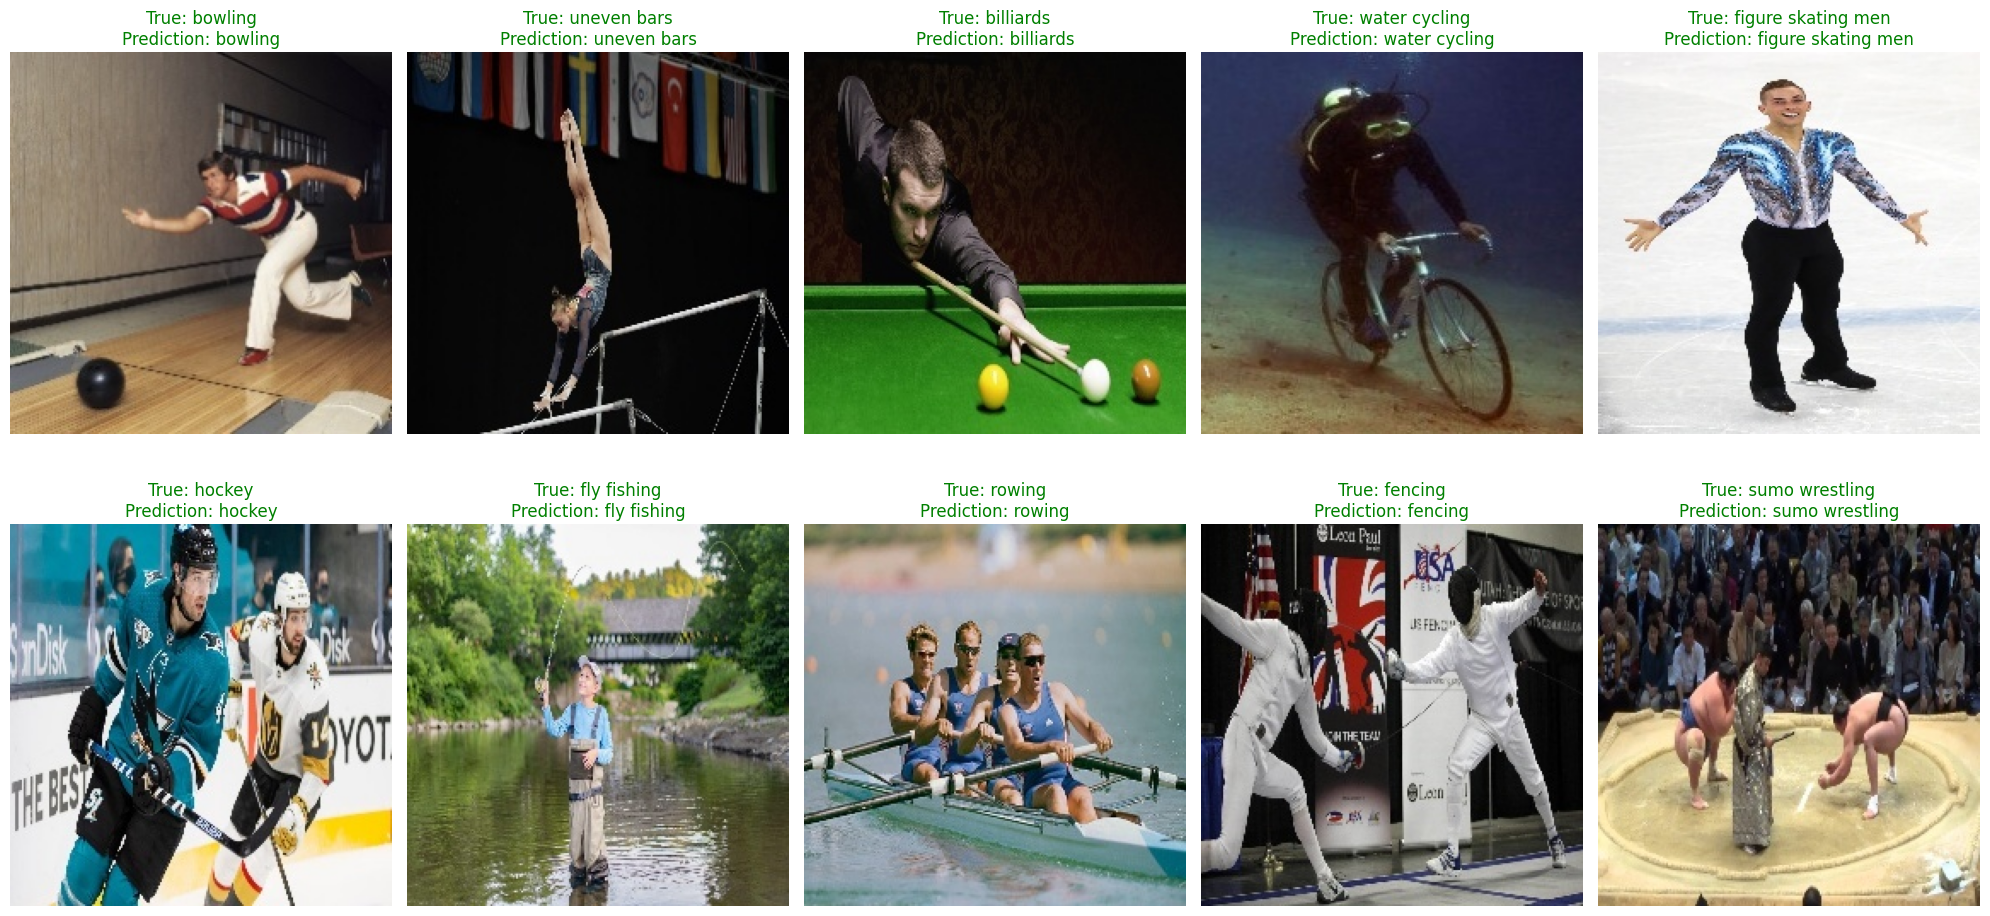

In [40]:
test_filenames = test_iterator.filenames
test_base_dir_path = test_iterator.directory


num_samples_to_show = 10
plt.figure(figsize=(20, 10))

random_indices = np.random.choice(len(test_filenames), num_samples_to_show, replace=False)

for i, idx in enumerate(random_indices):
    img_filename_relative = test_filenames[idx]
    img_path = os.path.join(test_base_dir_path, img_filename_relative)

    img = keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)
    predicted_label_idx = np.argmax(prediction)

    true_label_idx = test_iterator.classes[idx]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_names[true_label_idx]}\nPrediction: {class_names[predicted_label_idx]}",
              color='green' if true_label_idx == predicted_label_idx else 'red')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Technical Analysis of Sports Image Classification Model

In the sports image classification problem, the developed deep learning model achieved a high accuracy rate of 94.6% on the independent test dataset, far exceeding the specified targets. This success is quite remarkable, especially for a complex classification task with a high number of classes such as 100 different sports categories.

The factors and technical approaches underlying this superior performance are as follows:

### The Power of Transfer Learning (MobileNetV2):

The backbone of the model is MobileNetV2, a Convolutional Neural Network (CNN) pre-trained on a large-scale and diverse dataset such as ImageNet. The deep and multi-layered architecture of MobileNetV2 has learnt to efficiently extract low-level (edges, textures) and high-level (object parts, shapes) features of images.

Freezing these "feature extractor" layers **(trainable=False)** ensured that the universal visual representations learnt by the model from ImageNet were preserved. This approach allowed the model to quickly specialise on high-level features even with our limited dataset, as opposed to training the model from scratch.

### Efficient Classification Head:

The ‘classification head’, consisting of new trainable dense layers added on top of the frozen MobileNetV2 base, was successful in mapping these rich extracted features to 100 different sport categories. The use of the GlobalAveragePooling2D layer effectively reduced the size of the convolution outputs while preserving important information, allowing the model to be trained faster and with fewer parameters.

### Optimisation Strategies:

* **Adam Optimiser:** The use of the Adam optimisation algorithm with a low learning rate (learning_rate=0.0001) allowed the model to converge steadily and accurately towards the global minimum.

* **Data Augmentation:** Real-time data augmentation (e.g., rotation, zooming, horizontal flip) applied to the training dataset significantly improved the generalisation ability of the model by allowing it to see different variations of the images at each epoch. Although this caused the training accuracy to be initially lower than the validation accuracy, it reinforced the robustness of the model to unseen data.

### Callback Mechanisms:

**EarlyStopping:** If the verification loss does not improve for a certain number of epochs, the training is automatically stopped, preventing unnecessary computation time and ensuring that the model with the best generalisation performance is saved without overfitting.

### Conclusion
The achieved 94.6% test accuracy clearly demonstrates that, through the combination of Transfer Learning, careful architectural design, and effective optimization techniques, high-performing solutions can be developed even for image classification problems with a large number of classes. The model has proven its capability to accurately recognize and classify sports images with remarkable success.